
# Streaming Data for Predictive Maintenance with Linear Regression-Based Alerts

#Section 1 : Setup

This section imports all necessary libraries for data manipulation, visualization, machine learning, and database connectivity. It also loads environment variables securely using dotenv, which allows access to the PostgreSQL database without exposing credentials


In [8]:
# Section 1: Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from dotenv import load_dotenv
import psycopg2
import os



#Section 2 : Connect to Neon and Load Training Data

Here, we connect to a cloud-based PostgreSQL database hosted on Neon.tech. We query historical sensor readings from the CATDC_DATA_FEED table, selecting FEED_ID, TIMESTAMP, and READING. The data is reshaped using a pivot table to organize readings across 8 axes, and an Elapsed time column is created to serve as the independent variable for regression.


In [9]:
# Section 2: Connect to Neon and Load Training Data
load_dotenv()
DB_URL = os.getenv("DATABASE_URL")

def run_sql(sql: str, params=None):
    with psycopg2.connect(DB_URL) as conn:
        with conn.cursor() as cur:
            cur.execute(sql, params or [])
            return cur.fetchall()

query = """
SELECT TIMESTAMP, FEED_ID, READING
FROM CATDC_DATA_FEED
ORDER BY TIMESTAMP ASC
"""
rows = run_sql(query)
# Check which FEED_IDs are present in the database
feed_ids = run_sql("SELECT DISTINCT FEED_ID FROM CATDC_DATA_FEED;")
print("Available FEED_IDs:", [row[0] for row in feed_ids])

df_raw = pd.DataFrame(rows, columns=["Time", "Axis", "Reading"])
df_raw['Time'] = pd.to_datetime(df_raw['Time'])

# Handle duplicates using pivot_table
df = df_raw.pivot_table(index='Time', columns='Axis', values='Reading', aggfunc='mean').reset_index()

# Dynamically rename columns
df.columns = ['Time'] + [f'Axis{int(col)}' for col in df.columns[1:]]
df['Elapsed'] = (df['Time'] - df['Time'].iloc[0]).dt.total_seconds()
axes_cols = [f'Axis{i}' for i in range(1, 9)]


Available FEED_IDs: [8, 7, 1, 5, 2, 4, 6, 3]


#Section 3 : Train Regression Models and Plot

For each axis (Axis1–Axis8), we fit a univariate linear regression model using Elapsed time as the predictor. This models the expected current behavior over time. We store the slope and intercept for each axis and visualize the actual vs predicted readings using scatter plots and regression lines. These plots help assess model fit and underlying trends.




Available axes in DataFrame: ['Time', 'Axis1', 'Axis2', 'Axis3', 'Axis4', 'Axis5', 'Axis6', 'Axis7', 'Axis8', 'Elapsed', 'Axis1_z', 'Axis2_z', 'Axis3_z', 'Axis4_z', 'Axis5_z', 'Axis6_z', 'Axis7_z', 'Axis8_z']
Axis
1    440
5    425
4    425
3    425
6    424
8    424
7    424
2    424
Name: count, dtype: int64
Axis1: slope = -0.0001, intercept = 1.5647


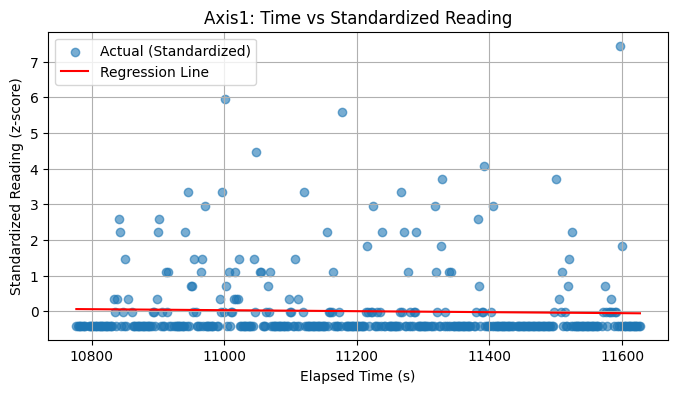

Axis2: slope = -0.0000, intercept = 0.5458


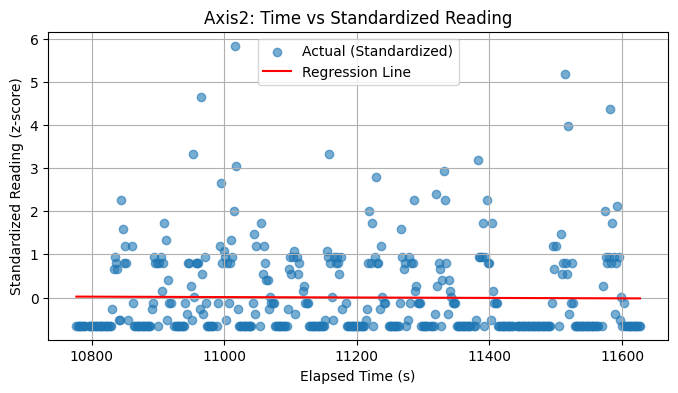

Axis3: slope = -0.0003, intercept = 2.9332


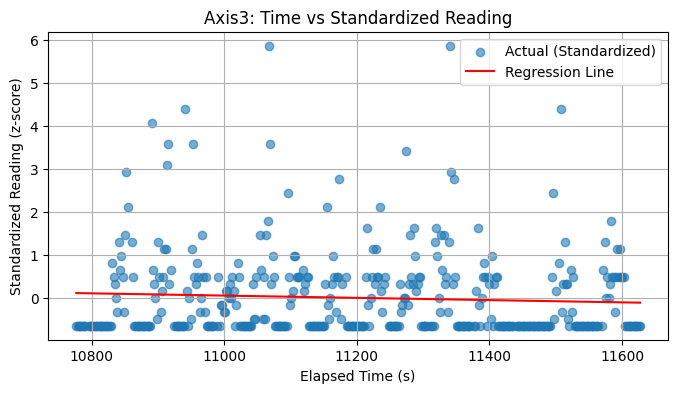

Axis4: slope = -0.0002, intercept = 2.7524


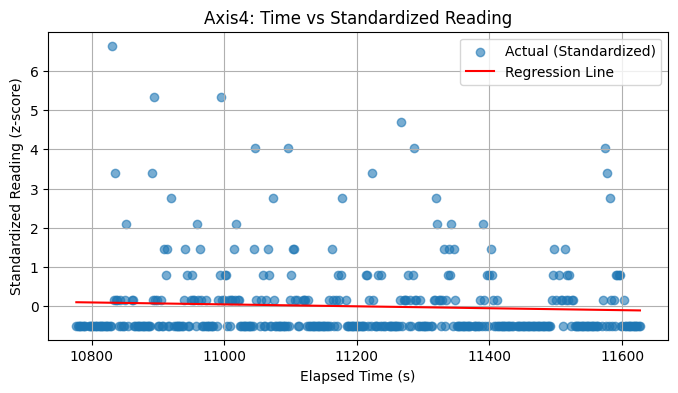

Axis5: slope = -0.0004, intercept = 4.1258


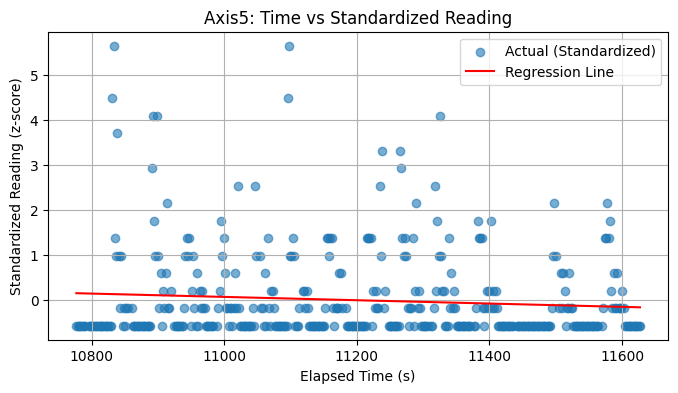

Axis6: slope = -0.0003, intercept = 3.2579


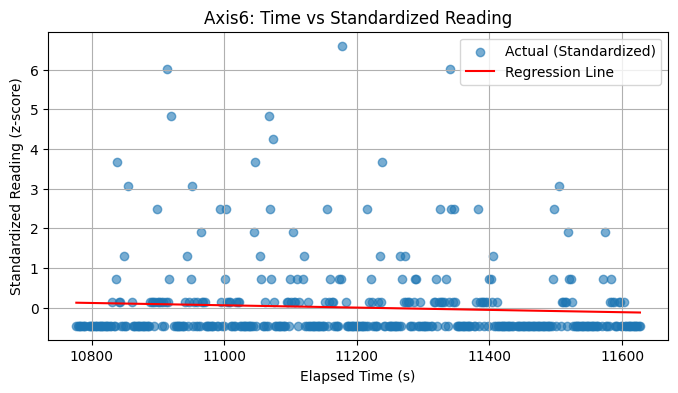

Axis7: slope = -0.0000, intercept = 0.3990


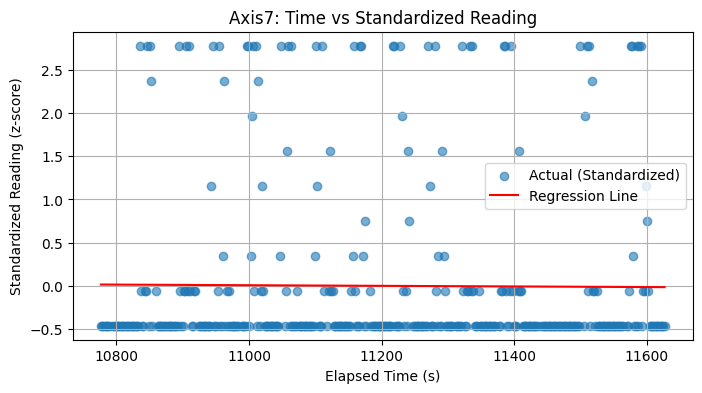

Axis8: slope = 0.0001, intercept = -1.4157


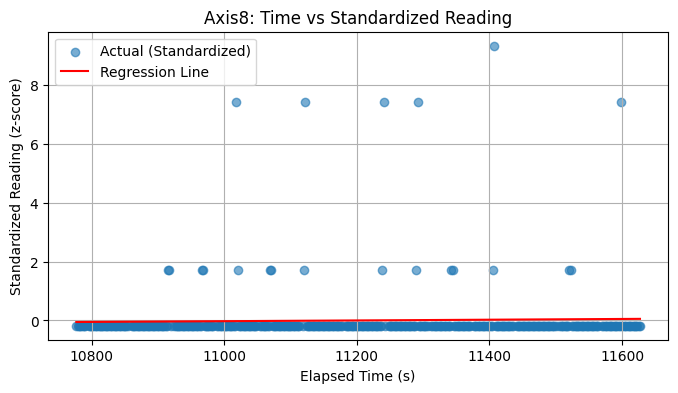

In [10]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Initialize storage
models = {}
coeffs = {}

# Step 1: Clean the data
df_clean = df.dropna(subset=axes_cols + ['Elapsed']).copy()

# Step 2: Normalize each axis (0–1 scale)
for axis in axes_cols:
    min_val = df_clean[axis].min()
    max_val = df_clean[axis].max()
    df_clean.loc[:, axis] = (df_clean[axis] - min_val) / (max_val - min_val)

# Step 3: Standardize each axis (z-score)
for axis in axes_cols:
    mean = df_clean[axis].mean()
    std = df_clean[axis].std()
    df_clean.loc[:, f'{axis}_z'] = (df_clean[axis] - mean) / std

# Step 4: Train regression models on standardized data
available_axes = [col for col in axes_cols if f'{col}_z' in df_clean.columns]
print("Available axes in DataFrame:", df_clean.columns.tolist())
print(df_raw['Axis'].value_counts())  # Optional: for reference

for axis in available_axes:
    X = df_clean[['Elapsed']]
    y = df_clean[f'{axis}_z']  # Use standardized values for training

    model = LinearRegression().fit(X, y)
    models[axis] = model
    coeffs[axis] = (model.coef_[0], model.intercept_)
    print(f"{axis}: slope = {coeffs[axis][0]:.4f}, intercept = {coeffs[axis][1]:.4f}")

    # Plot scatter + regression line
    y_pred = model.predict(X)
    plt.figure(figsize=(8, 4))
    plt.scatter(X, y, label='Actual (Standardized)', alpha=0.6)
    plt.plot(X, y_pred, color='red', label='Regression Line')
    plt.title(f'{axis}: Time vs Standardized Reading')
    plt.xlabel('Elapsed Time (s)')
    plt.ylabel('Standardized Reading (z-score)')
    plt.legend()
    plt.grid(True)
    plt.show()

#Section 4 : Residual Analysis

Residuals are calculated as the difference between actual readings and model predictions. We visualize these residuals using boxplots to identify outliers and assess the spread. This analysis is critical for understanding model accuracy and variability, which informs our threshold discovery.




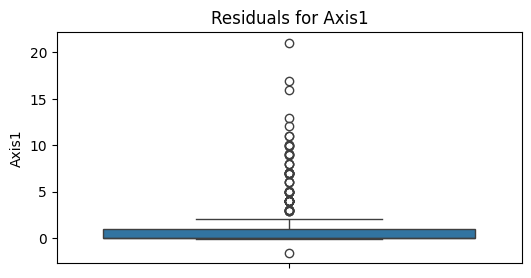

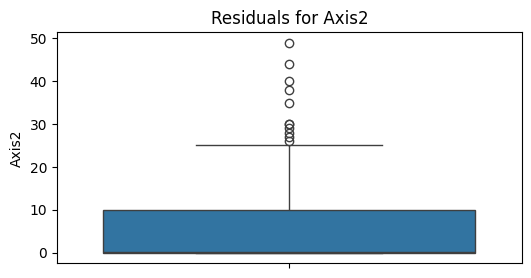

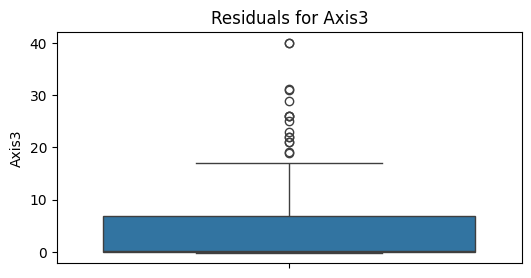

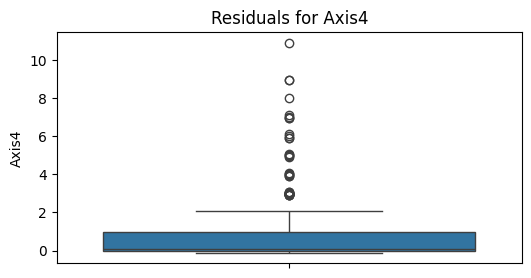

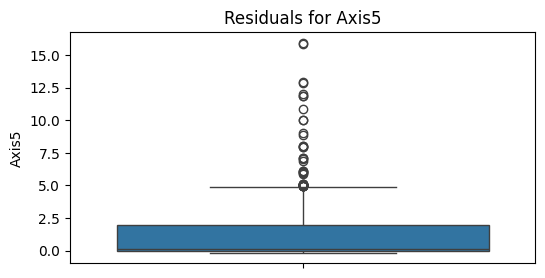

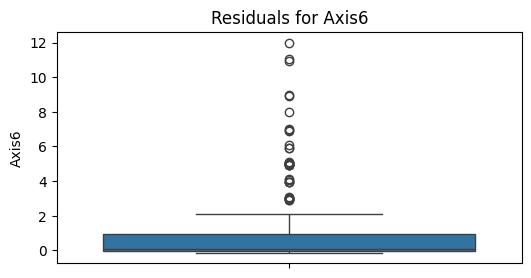

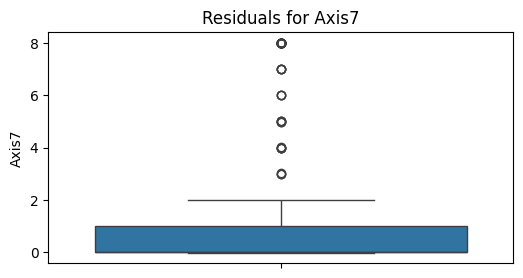

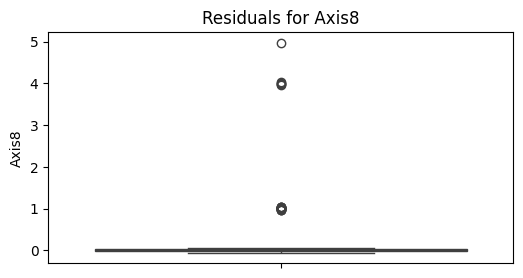

In [11]:
# Section 4: Residual Analysis
residuals = {}
for axis in axes_cols:
    predicted = models[axis].predict(df[['Elapsed']])
    residuals[axis] = df[axis] - predicted

    plt.figure(figsize=(6, 3))
    sns.boxplot(y=residuals[axis])
    plt.title(f'Residuals for {axis}')
    plt.show()

#Section 5 : Discover Thresholds

We define two thresholds for each axis:
- MinC: Minimum deviation to trigger an alert
- MaxC: Maximum deviation to trigger an error
These thresholds are derived from the standard deviation of residuals:
- MinC = std × 1.5
- MaxC = std × 3
We also define T = 6 seconds as the minimum duration a deviation must persist to be considered significant. This approach ensures thresholds are data-driven and tailored to each axis.


In [12]:
# Section 5: Discover Thresholds
thresholds = {}
for axis in residuals:
    std = residuals[axis].std()
    thresholds[axis] = {'MinC': std * 1.5, 'MaxC': std * 3}
T = 6  # seconds

#Section 6: Generate Synthetic Testing Data

We simulate test data using Gaussian noise based on the mean and standard deviation of each axis from the training set. The synthetic data mimics real-time sensor behavior and is timestamped to simulate streaming. We apply min-max normalization and z-score standardization to align the test data with the training distribution.


In [13]:
# Section 6: Generate Synthetic Testing Data
n_test = 100
elapsed_test = np.linspace(df['Elapsed'].min(), df['Elapsed'].max(), n_test)

synthetic = pd.DataFrame({'Elapsed': elapsed_test})
for axis in axes_cols:
    mean = df[axis].mean()
    std = df[axis].std()
    synthetic[axis] = np.random.normal(loc=mean, scale=std, size=n_test)



synthetic['Time'] = pd.date_range(start=df['Time'].iloc[-1] + pd.Timedelta(seconds=2),
                                  periods=n_test, freq='2s')

# Normalize and Standardize
for axis in axes_cols:
    min_val = df[axis].min()
    max_val = df[axis].max()
    synthetic[axis] = (synthetic[axis] - min_val) / (max_val - min_val)

for axis in axes_cols:
    mean = df[axis].mean()
    std = df[axis].std()
    synthetic[f'{axis}_z'] = (synthetic[axis] - mean) / std
print(synthetic.head())


      Elapsed     Axis1     Axis2     Axis3     Axis4     Axis5     Axis6  \
0    0.000000  0.372513  0.159415  0.228436  0.194465  0.087703  0.132320   
1  117.464323  0.266524 -0.080670  0.464750  0.059685 -0.167344  0.198941   
2  234.928646  0.068207  0.258642  0.148899  0.330882  0.261565  0.254856   
3  352.392970  0.284713  0.247747  0.074599  0.174191  0.226692 -0.091087   
4  469.857293  0.082979  0.236625  0.208957 -0.021347  0.153586 -0.109310   

      Axis7     Axis8                    Time   Axis1_z   Axis2_z   Axis3_z  \
0  0.122734  0.028966 2022-10-17 15:32:14.628 -0.266991 -0.631838 -0.608342   
1  0.116910 -0.029367 2022-10-17 15:32:16.628 -0.306725 -0.663656 -0.569793   
2 -0.547028  0.209430 2022-10-17 15:32:18.628 -0.381071 -0.618687 -0.621317   
3 -0.503133 -0.173595 2022-10-17 15:32:20.628 -0.299906 -0.620131 -0.633437   
4  0.498412  0.141318 2022-10-17 15:32:22.628 -0.375533 -0.621605 -0.611520   

    Axis4_z   Axis5_z   Axis6_z   Axis7_z   Axis8_z  
0 -0.365

#Section 7: Detect Alerts and Errors

Using the trained models, we predict expected readings on the synthetic data and compute residuals. We apply a rolling window detection algorithm to identify sustained deviations:
- Alert: Residual ≥ MinC for ≥ T seconds
- Error: Residual ≥ MaxC for ≥ T seconds
Detected events are logged with axis name, start/end time, type, and duration.


In [17]:
# Section 7: Detect Alerts and Errors
def detect_events(residuals, minC, maxC, T, interval=2):
    alerts, errors = [], []
    count = 0
    for i, r in enumerate(residuals):
        if abs(r) >= maxC:
            count += 1
            if count * interval >= T:
                errors.append((i - count, i))
        elif abs(r) >= minC:
            count += 1
            if count * interval >= T:
                alerts.append((i - count, i))
        else:
            count = 0
    return alerts, errors

event_log = []

for axis in axes_cols:
    predicted = models[axis].predict(synthetic[['Elapsed']])
    residual = synthetic[axis] - predicted
    minC = thresholds[axis]['MinC']
    maxC = thresholds[axis]['MaxC']
    alerts, errors = detect_events(residual, minC, maxC, T)

    for start, end in alerts:
        if 0 <= start < len(synthetic['Time']) and 0 <= end < len(synthetic['Time']):
            event_log.append([
                axis,
                synthetic['Time'].iloc[start],
                synthetic['Time'].iloc[end],
                'Alert',
                (end - start) * 2
            ])

    for start, end in errors:
        if 0 <= start < len(synthetic['Time']) and 0 <= end < len(synthetic['Time']):
            event_log.append([
                axis,
                synthetic['Time'].iloc[start],
                synthetic['Time'].iloc[end],
                'Error',
                (end - start) * 2
            ])

#Section 8: Visualize Regression + Alerts

We plot actual vs predicted readings for each axis and overlay shaded regions to highlight alerts (yellow) and errors (red). Each event is annotated with its duration. These visualizations provide intuitive insight into system behavior and anomaly detection.
- X-axis: Elapsed time in seconds
- Y-axis: Current readings (normalized)


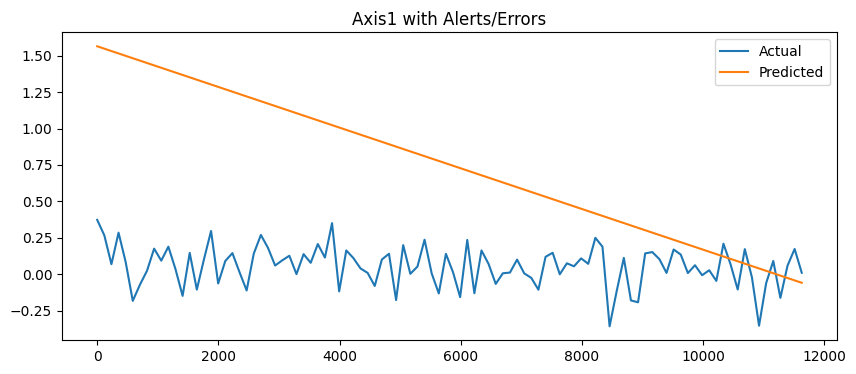

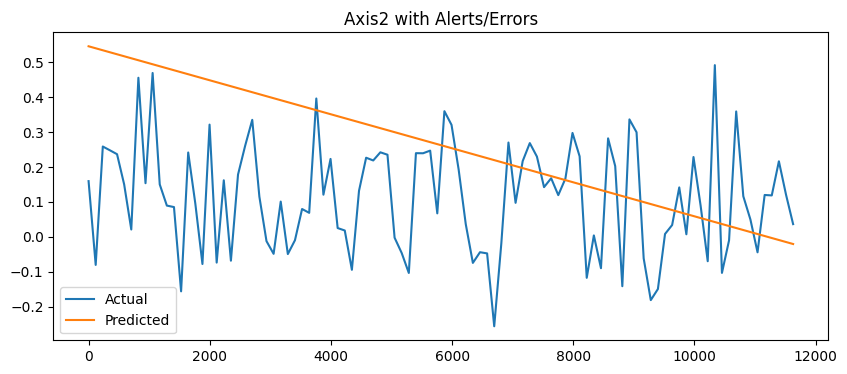

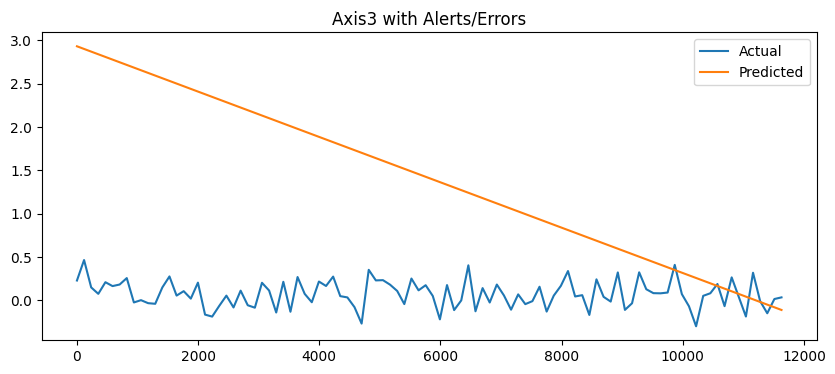

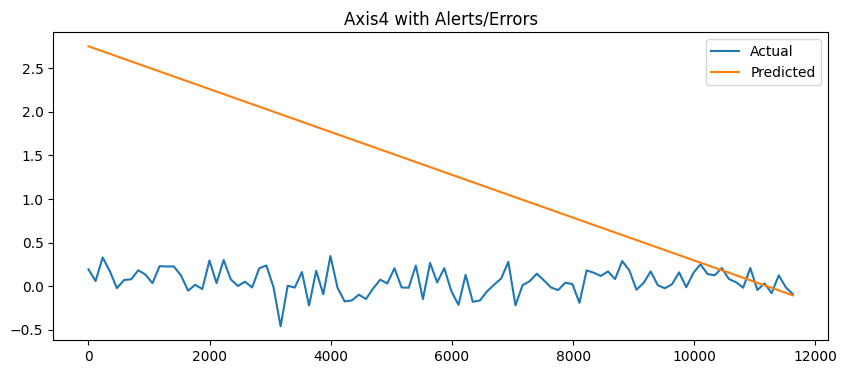

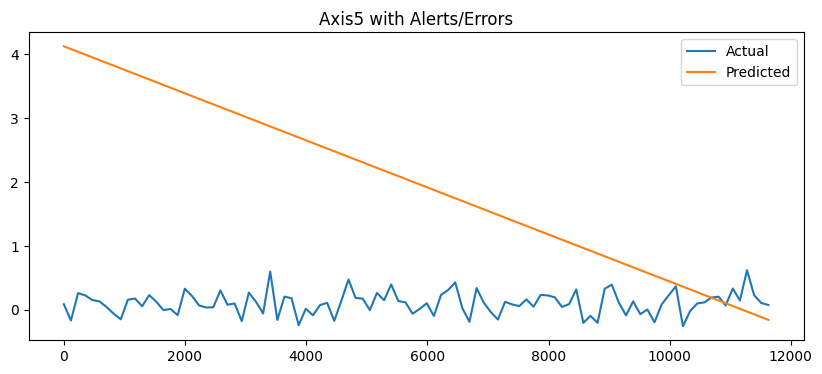

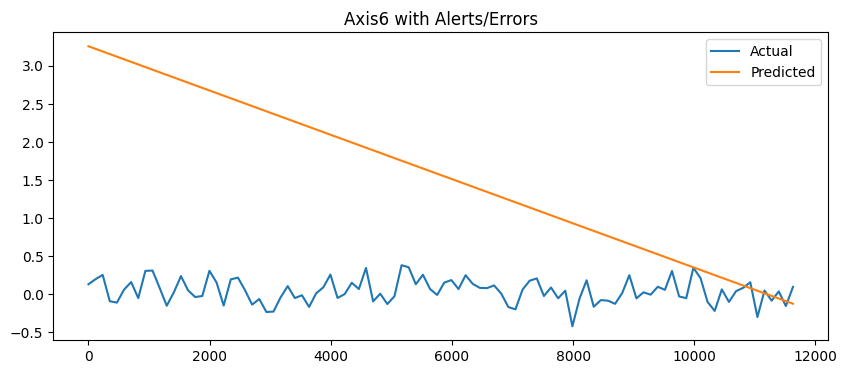

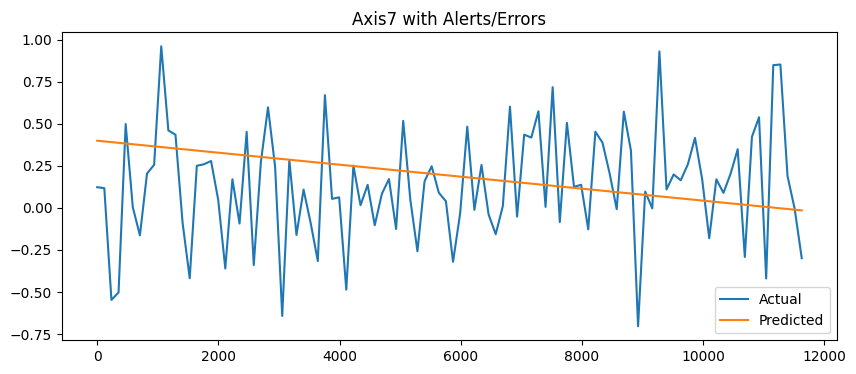

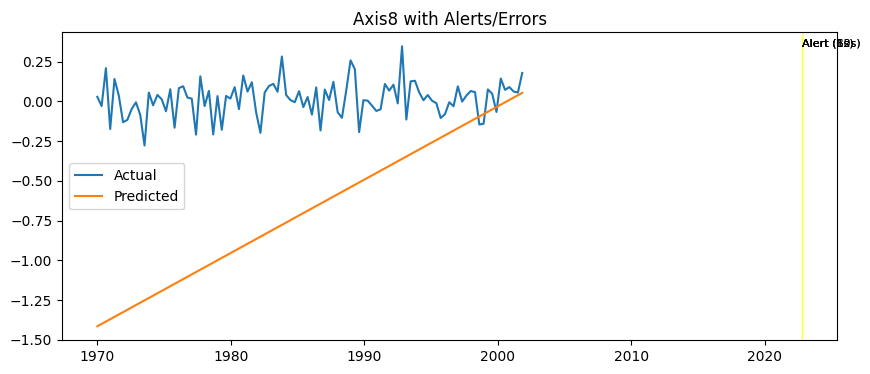

In [18]:
# Section 8: Visualize Regression + Alerts
for axis in axes_cols:
    plt.figure(figsize=(10, 4))
    plt.plot(synthetic['Elapsed'], synthetic[axis], label='Actual')
    plt.plot(synthetic['Elapsed'], models[axis].predict(synthetic[['Elapsed']]), label='Predicted')

    for event in event_log:
        if event[0] == axis:
            color = 'red' if event[3] == 'Error' else 'yellow'
            plt.axvspan(event[1], event[2], color=color, alpha=0.3)
            plt.text(event[1], max(synthetic[axis]), f"{event[3]} ({event[4]}s)", fontsize=8)

    plt.title(f'{axis} with Alerts/Errors')
    plt.legend()
    plt.show()

#Section 9: Log Results

All detected events are stored in a structured DataFrame and exported to event_log.csv. This log can be used for reporting, dashboard integration, or further analysis.


In [19]:
# Section 9: Log Results
event_df = pd.DataFrame(event_log, columns=['Axis', 'Start', 'End', 'Type', 'Duration'])
os.makedirs("../data", exist_ok=True)
event_df.to_csv("../data/event_log.csv", index=False)
event_df.head()

,Axis,Start,End,Type,Duration
0,Axis8,2022-10-17 15:33:30.628,2022-10-17 15:33:36.628,Alert,6
1,Axis8,2022-10-17 15:33:30.628,2022-10-17 15:33:38.628,Alert,8
2,Axis8,2022-10-17 15:33:30.628,2022-10-17 15:33:40.628,Alert,10
3,Axis8,2022-10-17 15:33:30.628,2022-10-17 15:33:42.628,Alert,12
